In [50]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [51]:
# Load your dataset
data = pd.read_csv("data/data.csv")

data = data[["Date", "Close"]]
# Convert Date column to datetime
data["Date"] = pd.to_datetime(data["Date"])

# Sort data by date
data.sort_values("Date", inplace=True)

# Normalizing the 'Close' prices

scaler = MinMaxScaler(feature_range=(0, 1))
data["Close"] = scaler.fit_transform(data["Close"].values.reshape(-1, 1))


# Function to create sequence and prediction
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i : (i + look_back)]  # Corrected line here
        X.append(a)
        Y.append(dataset[i + look_back])
    return np.array(X), np.array(Y)


# Create dataset with look_back period
look_back = 60
X, Y = create_dataset(data["Close"].values, look_back)
X = np.reshape(
    X, (X.shape[0], X.shape[1], 1)
)  # Reshape input to be [samples, time steps, features]

### About `create_dataset` function

This function, `create_dataset`, is designed to prepare your dataset for time series forecasting, specifically for training a neural network like an LSTM, which expects input in sequences.

### Purpose of the Function

The purpose of this function is to transform a series of price data into a format that an LSTM model can understand. LSTM models, and many other types of models used for time series forecasting, require input in sequences (or windows of data) to make predictions about future values.

### Parameters
- `dataset`: This is the array of your time series data, typically prices or other measurable metrics over time.
- `look_back`: This parameter determines the size of the "window" or the number of past observations to use as input to predict the next observation. It's a key parameter that defines how much historical data the model will consider to make a prediction.

### Process Inside the Function

1. **Initialize Two Lists (`X`, `Y`)**:
   - `X` will store the sequences of data that the model will learn from.
   - `Y` will store the outputs (or target values) that each sequence in `X` should predict.

2. **Loop Through the Dataset**:
   - The loop runs from the start of the dataset to `(len(dataset) - look_back)`. This is because for each point in the dataset, you need enough future data to create a full window (or sequence) plus one additional point to use as the target (prediction target).

3. **Create Sequences**:
   - Inside the loop, the line `a = dataset[i : (i + look_back)]` extracts a slice of the dataset starting from the current index `i` and spanning `look_back` elements forward. This slice represents a sequence of historical data that will be used as input for the model.

4. **Append to Lists**:
   - Each sequence `a` is appended to the list `X`.
   - The data point right after the end of each window, `dataset[i + look_back]`, is appended to the list `Y`. This is the target value that the model should learn to predict, based on the input sequence in `a`.

5. **Convert Lists to Arrays**:
   - Finally, the lists `X` and `Y` are converted to NumPy arrays and returned. This is because TensorFlow and similar libraries require data in this format to efficiently process and train models on.

### Visual Example

Imagine your dataset looks like this (simplified):
```
[10, 20, 30, 40, 50, 60, 70]
```
And you set `look_back = 3`. The function will create `X` and `Y` as follows:
- `X` = [[10, 20, 30], [20, 30, 40], [30, 40, 50], [40, 50, 60]]
- `Y` = [40, 50, 60, 70]

Each sequence in `X` is a list of three consecutive numbers from the dataset, and the corresponding value in `Y` is the number that comes right after each sequence.

### Conclusion

The `create_dataset` function is crucial for preparing data for time series analysis in machine learning, especially when using models that need to understand patterns over time, such as LSTMs. By converting raw data into a sequence format, it allows the model to learn to predict future values based on historical inputs.

In [52]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

C:\Users\mukha\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Model Definition and Layers

1. **Sequential Model Initialization:**
   ```python
   model = Sequential()
   ```
   - `Sequential()` creates a linear stack of layers in Keras, meaning each layer has exactly one input tensor and one output tensor. A `Sequential` model is appropriate here because you're building a straightforward feed-forward network where the output of one layer is the input to the next.

2. **Adding LSTM Layer:**
   ```python
   model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
   ```
   - `LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1))` adds an LSTM (Long Short-Term Memory) layer to the model.
   - `units=50`: This specifies that the layer will have 50 LSTM cells. This is a design choice that impacts both the capacity of the model and the computational load.
   - `return_sequences=True`: This is crucial when stacking LSTM layers. It makes the LSTM layer return the full sequence to the next layer instead of just the output of the last time step. This way, the next LSTM layer can perform further learning on the entire sequence.
   - `input_shape=(X.shape[1], 1)`: Specifies the shape of the input data that the layer will receive. Here, `X.shape[1]` is the number of time steps in each input sequence, and `1` indicates the number of features per time step (in this case, just the price).

3. **Adding Dropout Layer:**
   ```python
   model.add(Dropout(0.2))
   ```
   - `Dropout(0.2)` randomly sets 20% of the input units to 0 at each step during training, which helps prevent overfitting. Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their weights to zero) for each training sample. This makes the model less sensitive to the specific weights of neurons and more capable of generalizing well.

4. **Adding Another LSTM Layer:**
   ```python
   model.add(LSTM(units=50))
   ```
   - Another LSTM layer with 50 units. Note that `return_sequences` is not specified, so it defaults to `False`. This means this layer will only return the final output for each input sequence, which is appropriate for the output layer coming next.

5. **Adding Another Dropout Layer:**
   ```python
   model.add(Dropout(0.2))
   ```
   - Adds another dropout layer, again setting 20% of the input units to 0 at each step during training to help prevent overfitting.

6. **Adding Dense Layer:**
   ```python
   model.add(Dense(1))
   ```
   - `Dense(1)` adds a fully connected (dense) layer with one unit. This is the output layer of the network. It will output a single continuous value, which corresponds to the model's prediction for the next time step in the sequence.

### Compiling the Model

```python
model.compile(optimizer="adam", loss="mean_squared_error")
```
- `compile` configures the model for training.
- `optimizer="adam"`: Specifies the optimizer to use. Adam is an efficient stochastic optimization method that adjusts the weights based on how well the model is performing, a process measured by a loss function.
- `loss="mean_squared_error"`: Specifies the loss function to minimize. Mean Squared Error (MSE) is commonly used for regression problems (like predicting prices), and it works by finding the average squared difference between the predicted and actual values. Lower MSE values indicate a better model with fewer errors.

### Summary
This code builds an LSTM-based neural network suitable for forecasting tasks, where the goal is to predict future values from past sequence data. The model uses dropout for regularization and mean squared error as a measure of prediction accuracy. It’s a robust setup for tasks like predicting Bitcoin prices from historical data.

In [53]:
# Fit model
model.fit(X, Y, epochs=100, batch_size=32)

Epoch 1/100


84/84 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0329
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0018
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0015
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0012
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0015
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0014
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0012
Epoch 9/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0013
Epoch 10/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0013
Epoch 11/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011
Epoch 12/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0012
Epoch 13/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 9.9938e-04
Epoch 14/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0011
Epoch 15/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 9.28

84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


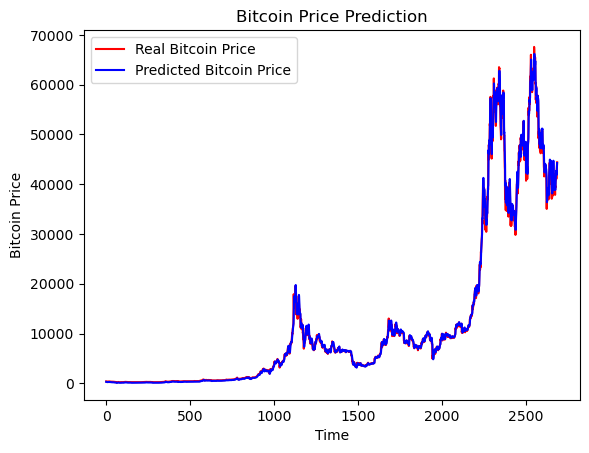

In [54]:
# Making predictions
predicted_price = model.predict(X)
predicted_price = scaler.inverse_transform(predicted_price)  # Undo scaling
inversed_real_price = scaler.inverse_transform(
    data["Close"].iloc[look_back:].values.reshape(-1, 1)
)

# Plot the results
plt.plot(inversed_real_price, color="red", label="Real Bitcoin Price")
plt.plot(predicted_price, color="blue", label="Predicted Bitcoin Price")
plt.title("Bitcoin Price Prediction")
plt.xlabel("Time")
plt.ylabel("Bitcoin Price")
plt.legend()
plt.show()

## How I can predict next 30 days?

To predict the Bitcoin prices for the next 30 days using your LSTM model, you'll follow a method that involves using the model's outputs as new inputs to predict future values iteratively. This is commonly referred to as a rolling or recursive prediction approach.

Here's how you can implement it:

### Step 1: Prepare the Last Available Sequence
Start with the last available sequence of data (the last `look_back` days of `Close` prices) that your model was trained on.

### Step 2: Recursive Forecasting
You will recursively use the model's predictions to forecast the next 30 days. This involves:
1. Predicting the next day’s price using the current input sequence.
2. Updating the input sequence to include the newly predicted price and remove the oldest price in the sequence.
3. Repeating this process for the next 29 days.


### Considerations
1. **Model Accuracy**: Remember, the accuracy of these predictions depends heavily on the model's performance and the nature of the data. Time series forecasting, especially for volatile entities like Bitcoin prices, can be challenging.
2. **Model Updating**: If new actual price data becomes available, consider retraining or fine-tuning your model periodically to maintain its accuracy.
3. **Future Inputs**: Since the predictions are used as inputs for future predictions, errors can accumulate quickly. Keep this in mind when interpreting the results.


In [55]:
# Assume `last_60_days` is a numpy array containing the last 60 days of scaled 'Close' prices
last_60_days = data["Close"].values[-look_back:]
current_batch = last_60_days.reshape((1, look_back, 1))

# List to hold the predictions
predicted_prices = []

for i in range(30):  # For each of the next 30 days
    # Get the prediction (note it's in the scaled format)
    predicted_price = model.predict(current_batch)[0]

    # Append to predictions
    predicted_prices.append(predicted_price)

    # Use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:, 1:, :], [[predicted_price]], axis=1)

# Rescale the predicted values back to the original price scale
predicted_prices = scaler.inverse_transform(predicted_prices)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

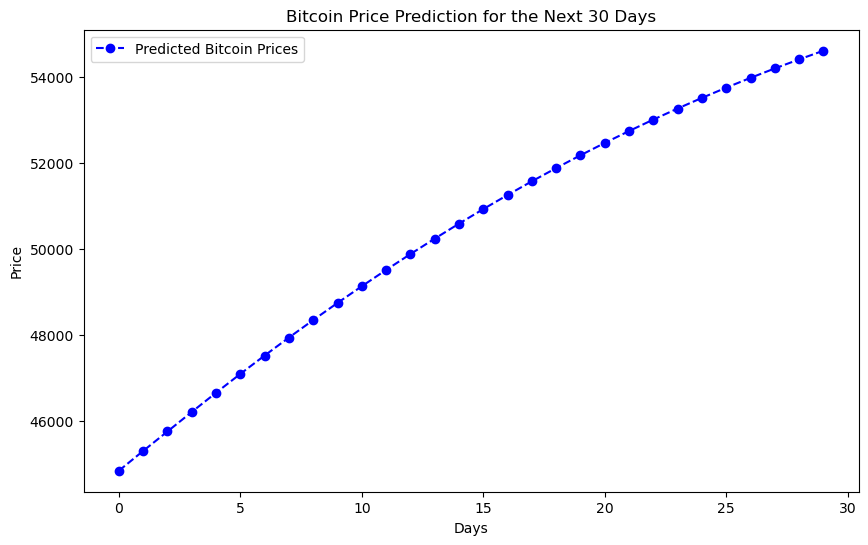

In [56]:
# Plotting the predicted prices
plt.figure(figsize=(10, 6))
plt.plot(
    predicted_prices,
    color="blue",
    marker="o",
    linestyle="dashed",
    label="Predicted Bitcoin Prices",
)
plt.title("Bitcoin Price Prediction for the Next 30 Days")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.show()

In [57]:
model.save("my_lstm_model.h5")